# Chapter 3: Faults

Here we will see how we can interpolate faults networks and how we can use them to offset the lithological model. For this example we will use the example of the first chapter adding a fault in the middle;

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../")

# Importing gempy


import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

In [2]:
geo_data = gp.read_pickle('BasicFault.pickle')

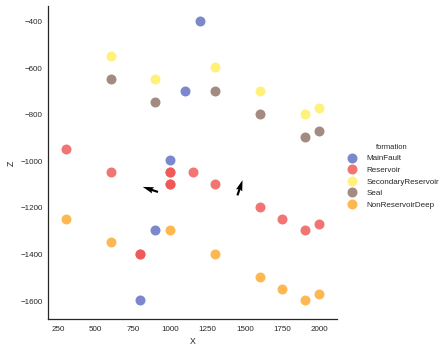

In [3]:
geo_data.geo_data_type= 3
gp.plot_data(geo_data)

In [4]:
gp.set_data_series(geo_data, {"fault":geo_data.formations[4], 
                      "Rest":np.delete(geo_data.formations, 4)},
                       order_series = ["fault",
                                       "Rest",
                                       ], verbose=0)

In [5]:
gp.get_raw_data(geo_data).head()

G_x  G_y  G_z       X       Y       Z  azimuth  dip  formation  \
interfaces 0  NaN  NaN  NaN   800.0  1000.0 -1600.0      NaN  NaN  MainFault   
           1  NaN  NaN  NaN  1200.0  1000.0  -400.0      NaN  NaN  MainFault   
           2  NaN  NaN  NaN  1100.0  1000.0  -700.0      NaN  NaN  MainFault   
           3  NaN  NaN  NaN   900.0  1000.0 -1300.0      NaN  NaN  MainFault   
           4  NaN  NaN  NaN  1000.0  1000.0 -1000.0      NaN  NaN  MainFault   

              isFault  order_series  polarity series  
interfaces 0     True             1       NaN  fault  
           1     True             1       NaN  fault  
           2     True             1       NaN  fault  
           3     True             1       NaN  fault  
           4     True             1       NaN  fault

In [6]:
interp_data = gp.InterpolatorInput(geo_data, u_grade=[3,3])

I am here
I am in the setting
float32
I am here
[2, 2]


In [7]:
sol = gp.compute_model(interp_data)

[3, 3]


In [8]:
geo_data.geo_data_type = 'a'

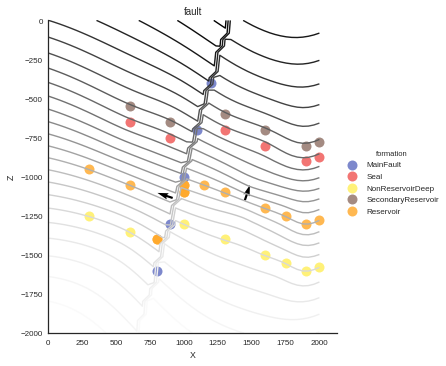

In [9]:
gp.plot_potential_field(geo_data, sol[1,:], 25, plot_data = True)

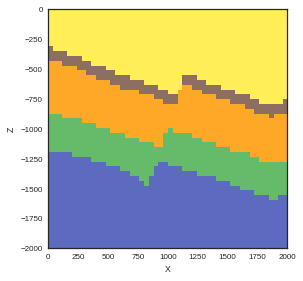

In [11]:
gp.plot_section(geo_data, sol[0,:], 25, plot_data = False)

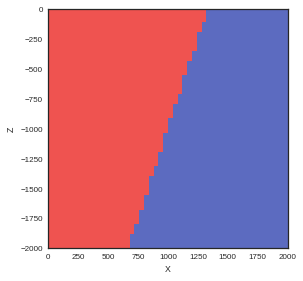

In [11]:
gp.plot_section(geo_data, sol[2,:], 25)